# End-to-End: очистка данных, EDA, препроцессинг и обучение модели

Этот ноутбук выполняет полный цикл: загрузка данных → очистка (дубликаты, пропуски) → EDA → построение препроцессинга → выбор модели через RandomizedSearchCV → сохранение артефактов и сабмита.


In [2]:
# Импорты и настройка
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import joblib
from scipy.stats import randint, uniform

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn import set_config
set_config(display='diagram')

# Пути и окружение
PROJECT_ROOT = Path(os.getcwd()).resolve()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent
SRC_DIR = PROJECT_ROOT / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

sns.set_style('whitegrid')
pd.options.display.max_columns = 120

print(f"Project Root: {PROJECT_ROOT}")


Project Root: /Users/apple/Desktop/Cursor/fast_api_ai


In [3]:
# Загрузка данных
TARGET = 'Heart Attack Risk (Binary)'
train_path = PROJECT_ROOT / 'heart_train.csv'
test_path = PROJECT_ROOT / 'heart_test.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Удаляем возможные индексные колонки
for df in [df_train, df_test]:
    cols_to_drop = [c for c in df.columns if 'unnamed' in c.lower()]
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)

X = df_train.drop(columns=[TARGET])
y = df_train[TARGET]

print("Формы:")
print("X:", X.shape, " y:", y.shape)
print("Пропусков в train:", int(df_train.isnull().sum().sum()))


Формы:
X: (8685, 26)  y: (8685,)
Пропусков в train: 2187


In [4]:
# Очистка: явные и неявные дубликаты
from itertools import chain

# Явные дубликаты по всем колонкам, кроме id
cols_wo_id = [c for c in df_train.columns if c != 'id']
mask_full_dups = df_train.duplicated(subset=cols_wo_id, keep='first')
num_full_dups = int(mask_full_dups.sum())
print(f"Явные дубликаты (без id): {num_full_dups}")

if num_full_dups > 0:
    df_train = df_train.loc[~mask_full_dups].reset_index(drop=True)
    y = df_train[TARGET]
    X = df_train.drop(columns=[TARGET])
    print("После удаления явных дубликатов:", X.shape)

# Неявные дубликаты: блокирующий ключ
num_cols_key = X.select_dtypes(include=np.number).columns.drop('id', errors='ignore')
cat_cols_key = X.select_dtypes(include=['object', 'category']).columns

X_key = X.copy()
for c in num_cols_key:
    X_key[c] = X_key[c].round(2)  # округление 2 знака

def make_key(row):
    parts = []
    for c in chain(cat_cols_key, num_cols_key):
        parts.append(f"{c}={row[c]}")
    return '|'.join(parts)

keys = X_key.apply(make_key, axis=1)
vc = keys.value_counts()
groups = vc[vc > 1].index
print(f"Групп потенциальных неявных дубликатов: {len(groups)}")

to_drop = []
for key in groups:
    idx = keys[keys == key].index
    targets = y.loc[idx]
    if targets.nunique() == 1:
        to_drop.extend(idx[1:])

print(f"К удалению (без конфликта таргета): {len(to_drop)}")
if to_drop:
    df_train = df_train.drop(index=to_drop).reset_index(drop=True)
    y = df_train[TARGET]
    X = df_train.drop(columns=[TARGET])
    print("После удаления неявных дубликатов:", X.shape)


Явные дубликаты (без id): 0
Групп потенциальных неявных дубликатов: 4
К удалению (без конфликта таргета): 4
После удаления неявных дубликатов: (8681, 26)


                                 missing  missing_%
Physical Activity Days Per Week      243        2.8
Diabetes                             243        2.8
Family History                       243        2.8
Smoking                              243        2.8
Obesity                              243        2.8
Alcohol Consumption                  243        2.8
Previous Heart Problems              243        2.8
Medication Use                       243        2.8
Stress Level                         243        2.8


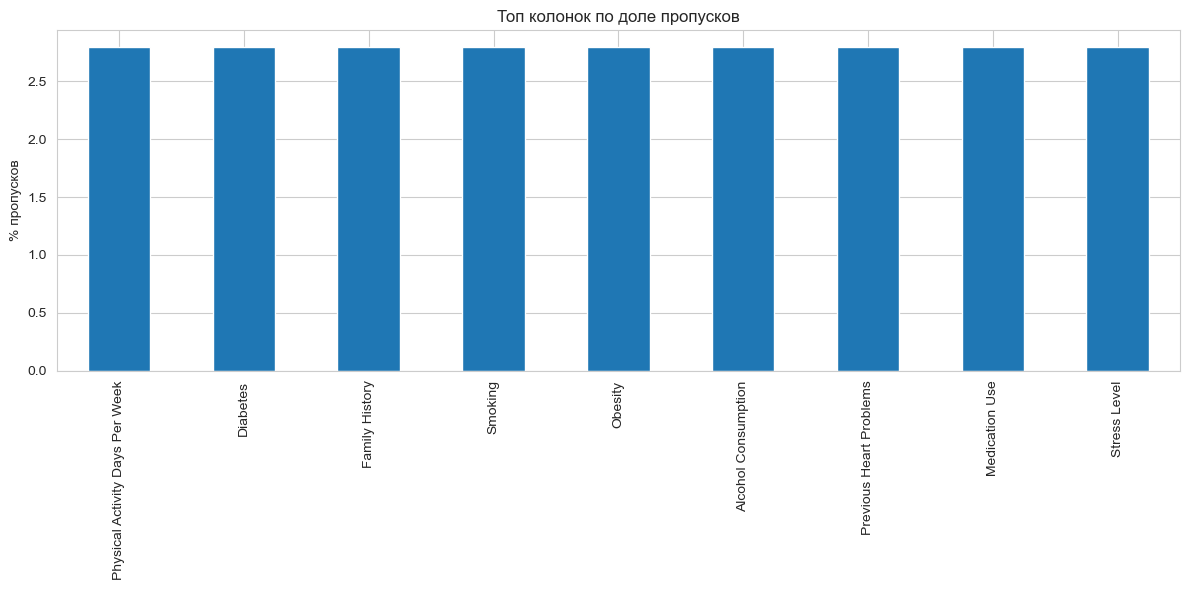

,column,mean_y_if_na,mean_y_if_notna
0,Physical Activity Days Per Week,0.0,0.35672
1,Diabetes,0.0,0.35672
2,Family History,0.0,0.35672
3,Smoking,0.0,0.35672
4,Obesity,0.0,0.35672
5,Alcohol Consumption,0.0,0.35672
6,Previous Heart Problems,0.0,0.35672
7,Medication Use,0.0,0.35672
8,Stress Level,0.0,0.35672


In [5]:
# Анализ пропусков
missing_counts = df_train.isnull().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df_train) * 100).round(2)
miss_df = pd.DataFrame({'missing': missing_counts, 'missing_%': missing_pct})
print(miss_df[miss_df['missing'] > 0].head(20))

plt.figure(figsize=(12, 6))
miss_df[miss_df['missing'] > 0]['missing_%'].head(20).plot(kind='bar')
plt.title('Топ колонок по доле пропусков')
plt.ylabel('% пропусков')
plt.tight_layout()
plt.show()

# Влияние пропусков на таргет
cols_with_missing = miss_df[miss_df['missing'] > 0].index.tolist()
impact_rows = []
for col in cols_with_missing:
    has_na = df_train[col].isna()
    if has_na.any():
        impact_rows.append((col, float(y[has_na].mean()), float(y[~has_na].mean())))
impact_df = pd.DataFrame(impact_rows, columns=['column', 'mean_y_if_na', 'mean_y_if_notna'])
impact_df.sort_values(by='mean_y_if_na', ascending=False).head(20)


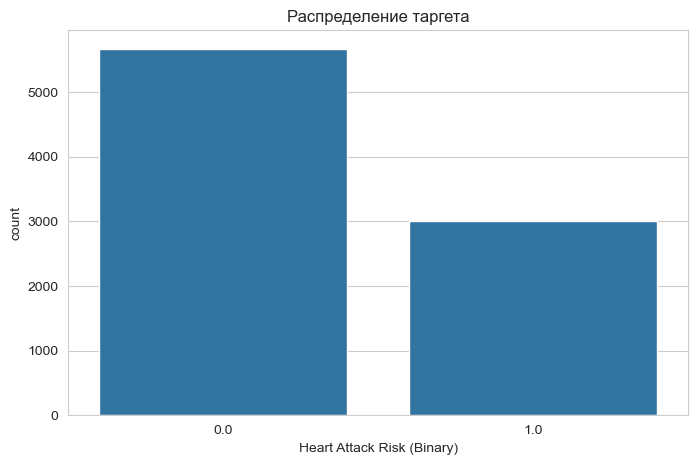

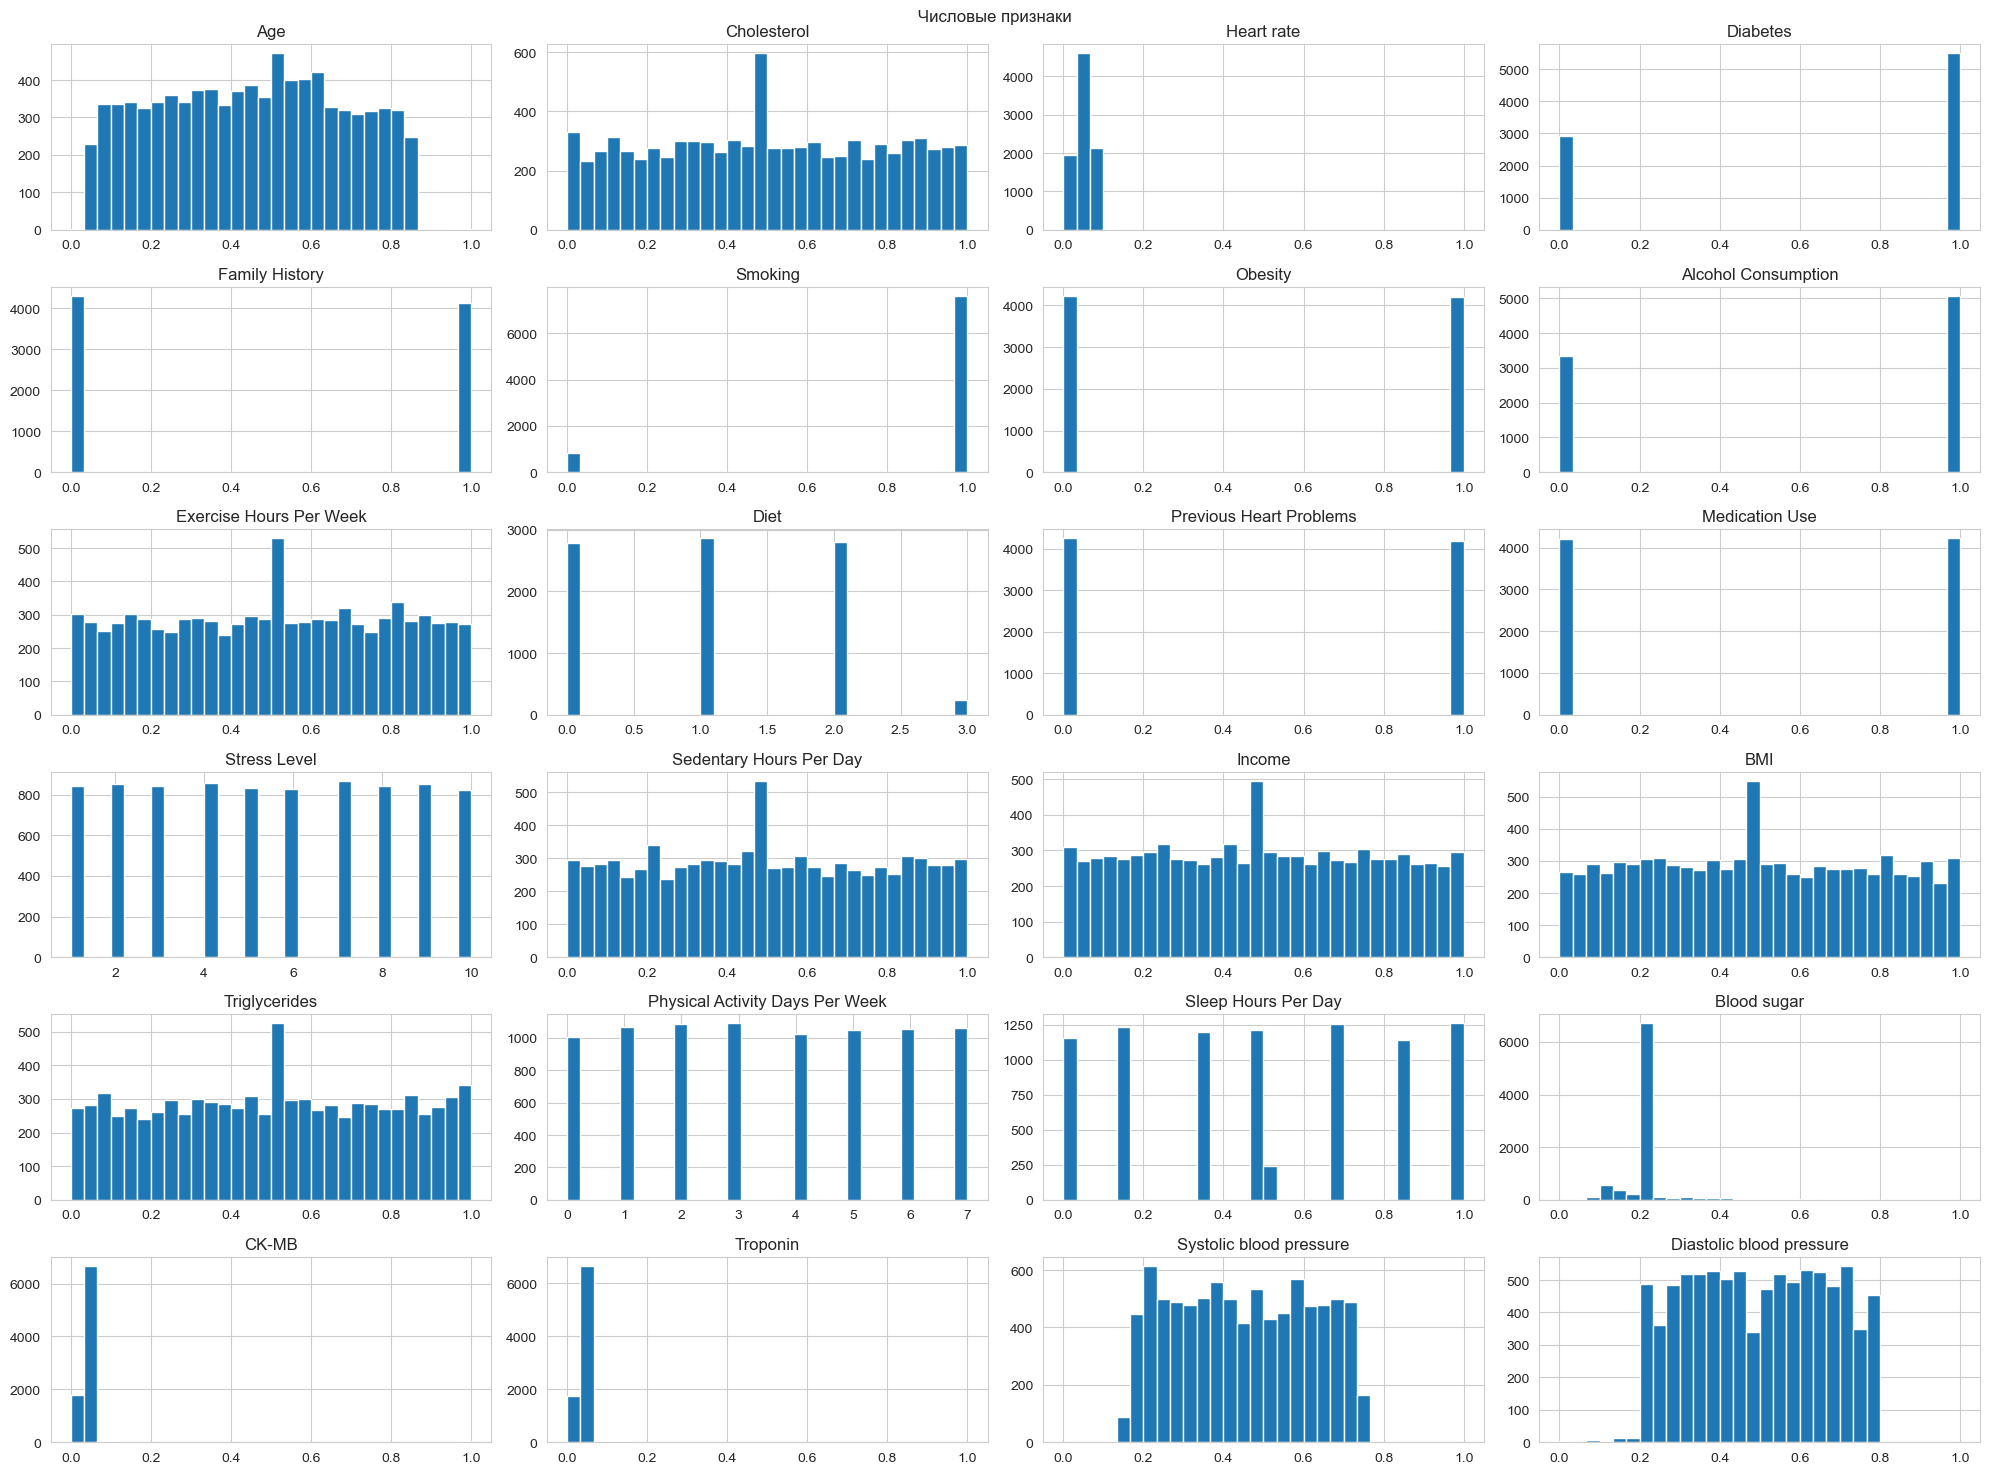

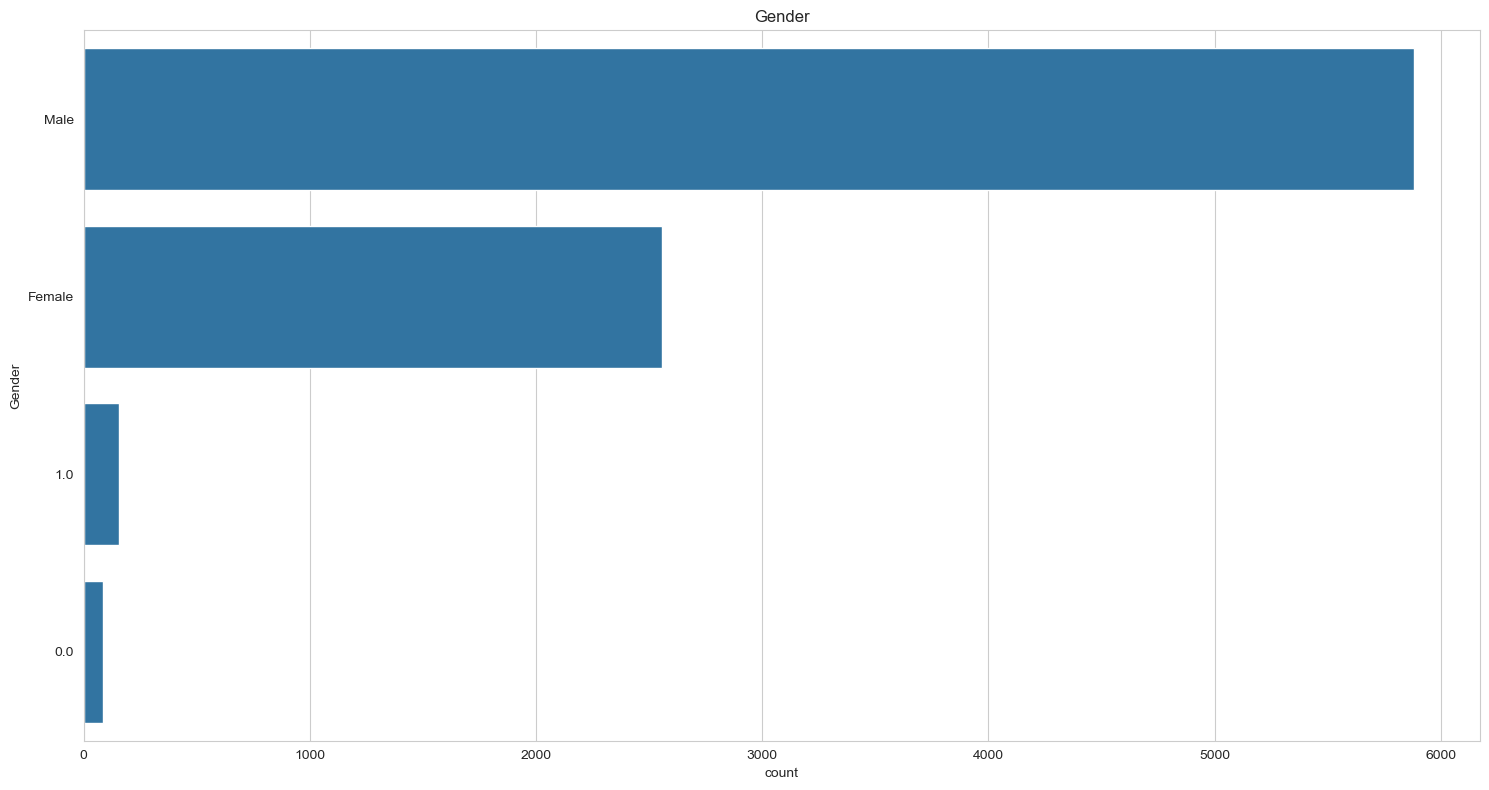

In [6]:
# EDA: таргет и распределения
plt.figure(figsize=(8, 5))
sns.countplot(x=y)
plt.title('Распределение таргета')
plt.show()

numeric_cols = X.select_dtypes(include=np.number).columns.drop('id', errors='ignore')
df_train[numeric_cols].hist(bins=30, figsize=(20, 15), layout=(-1, 4))
plt.suptitle('Числовые признаки')
plt.tight_layout()
plt.show()

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
plt.figure(figsize=(15, 8))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, len(categorical_cols), i+1)
    sns.countplot(y=df_train[col], order=df_train[col].value_counts().index)
    plt.title(col)
plt.tight_layout()
plt.show()


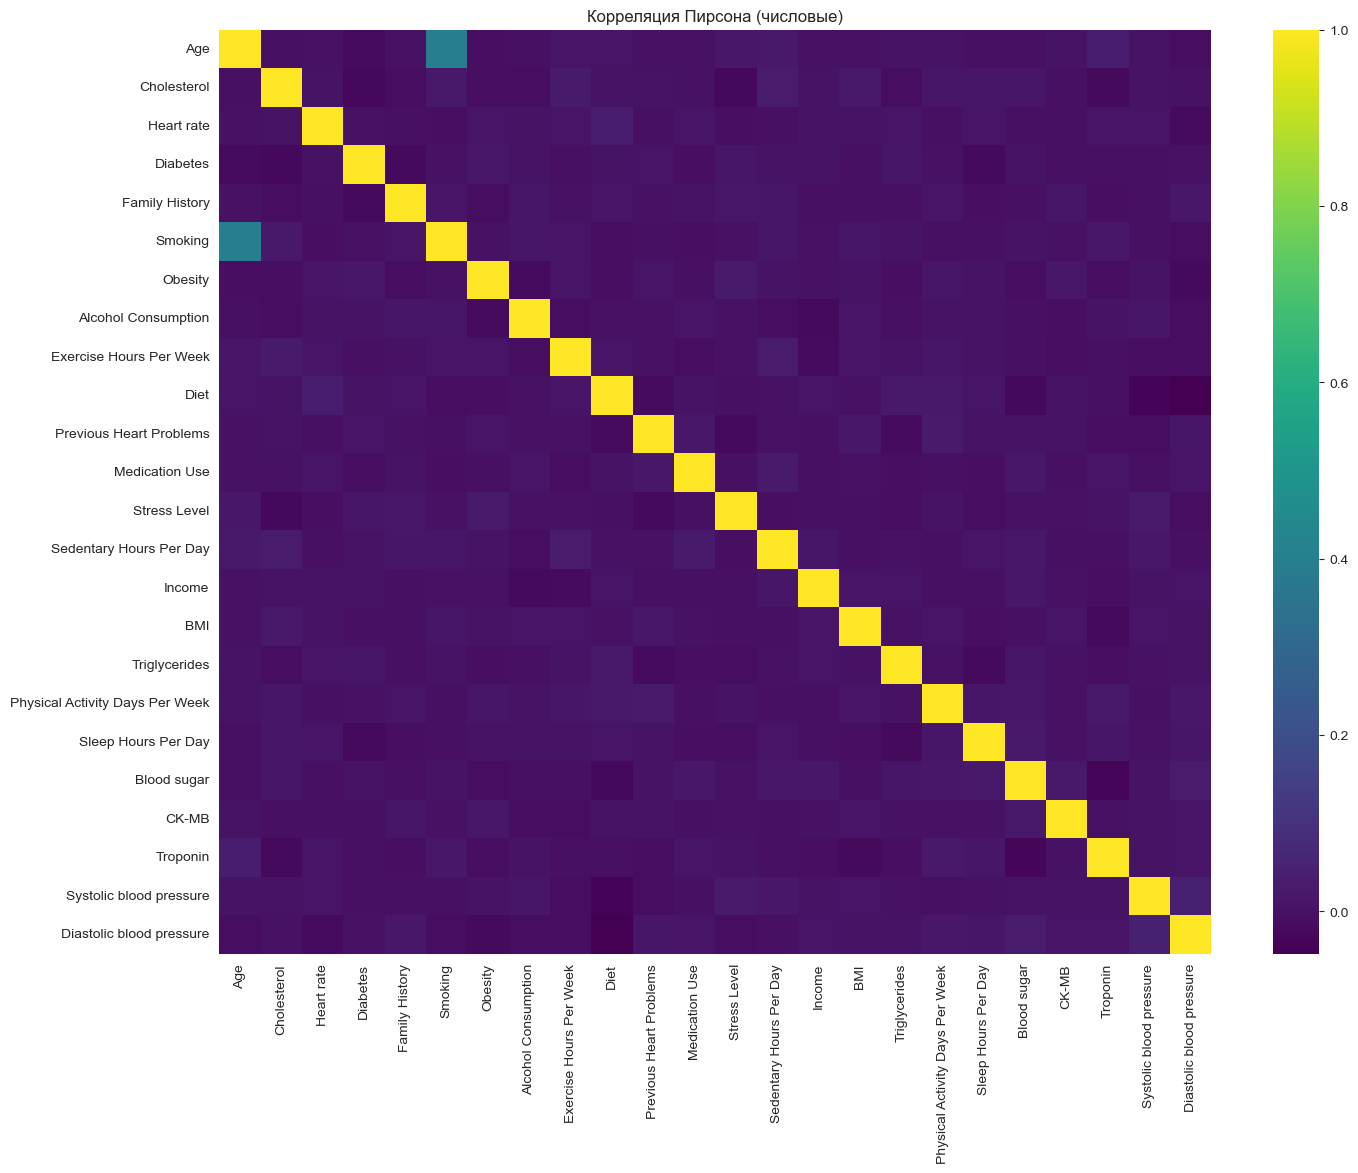

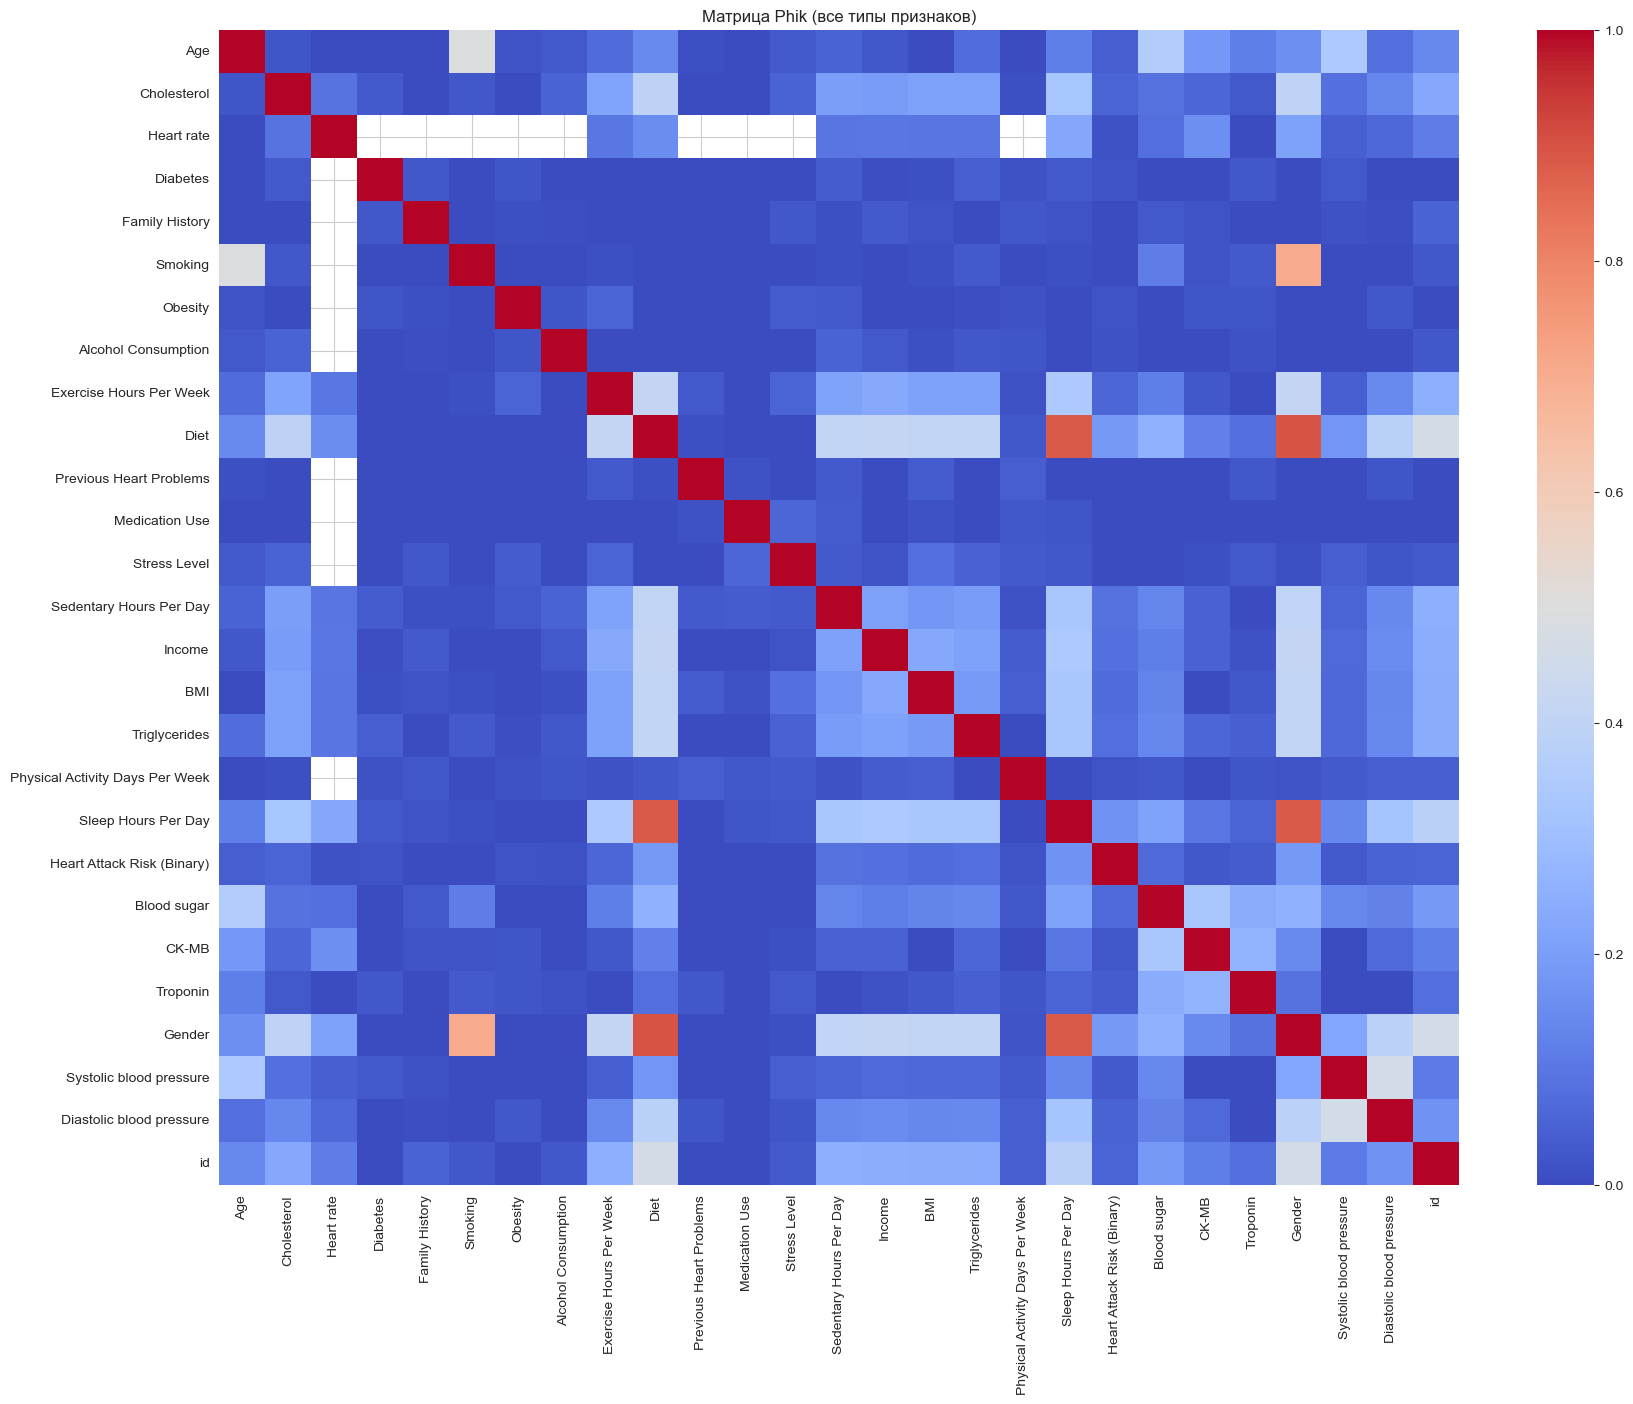

Heart Attack Risk (Binary)    1.000000
Diet                          0.186502
Gender                        0.184637
Sleep Hours Per Day           0.164105
Sedentary Hours Per Day       0.086832
Income                        0.082979
Triglycerides                 0.081993
BMI                           0.071472
Blood sugar                   0.068319
Exercise Hours Per Week       0.061914
Cholesterol                   0.057740
id                            0.054798
Diastolic blood pressure      0.053132
Age                           0.041919
Troponin                      0.035436
Name: Heart Attack Risk (Binary), dtype: float64

In [7]:
# Корреляции: Pearson и Phik
plt.figure(figsize=(16, 12))
corr_matrix = df_train[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap='viridis')
plt.title('Корреляция Пирсона (числовые)')
plt.show()

numeric_cols_for_phik = X.select_dtypes(include=np.number).columns.tolist()
phik_matrix = df_train.phik_matrix(interval_cols=numeric_cols_for_phik)
plt.figure(figsize=(20, 15))
sns.heatmap(phik_matrix, annot=False, cmap='coolwarm')
plt.title('Матрица Phik (все типы признаков)')
plt.show()

phik_target = phik_matrix[TARGET].sort_values(ascending=False)
phik_target.head(15)


In [8]:
# Препроцессинг с индикаторами пропусков
# Списки колонок
ohe_cols = [col for col in X.select_dtypes(include=['object', 'category']).columns if X[col].nunique() <= 3]
if 'Gender' in X.columns and 'Gender' not in ohe_cols:
    ohe_cols.append('Gender')

ordinal_cols = [col for col in X.select_dtypes(include=['object', 'category']).columns if X[col].nunique() > 3]
if 'Diet' in X.columns and 'Diet' not in ordinal_cols:
    ordinal_cols.append('Diet')

numeric_cols = X.select_dtypes(include=np.number).columns.drop('id', errors='ignore').tolist()

# Убираем пересечения
ohe_cols = list(set(ohe_cols) - set(ordinal_cols))
numeric_cols = list(set(numeric_cols) - set(ohe_cols) - set(ordinal_cols))

print(f"OHE: {ohe_cols}\nORD: {ordinal_cols}\nNUM: {numeric_cols[:8]} ... total {len(numeric_cols)}")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', StandardScaler())
])

ohe_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('ord', ordinal_transformer, ordinal_cols)
    ],
    remainder='drop'
)

preprocessor


OHE: []
ORD: ['Gender', 'Diet']
NUM: ['Physical Activity Days Per Week', 'Medication Use', 'Sleep Hours Per Day', 'Age', 'BMI', 'Heart rate', 'Blood sugar', 'Diabetes'] ... total 23


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Physical Activity Days Per Week',
                                  'Medication Use', 'Sleep Hours Per Day',
                                  'Age', 'BMI', 'Heart rate', 'Blood sugar',
                                  'Diabetes', 'Family History',
                                  'Exercise Hours Per Week', 'Cholesterol',
                                  'Smoking', 'Obesity',
                                  'Diastolic bloo...
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 []),
                                ('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Gender', 'Diet'])])

In [9]:
# Модели, поиск и сохранение
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression())])

param_dist = [
    {
        'classifier': [LogisticRegression(solver='liblinear', random_state=42)],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': uniform(0.1, 10),
    },
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': randint(100, 500),
        'classifier__max_depth': [10, 20, 30, None],
        'classifier__min_samples_leaf': randint(1, 5)
    },
    {
        'classifier': [GradientBoostingClassifier(random_state=42)],
        'classifier__n_estimators': randint(100, 500),
        'classifier__learning_rate': uniform(0.01, 0.2),
        'classifier__max_depth': randint(3, 8)
    },
    {
        'classifier': [XGBClassifier(random_state=42, eval_metric='logloss')],
        'classifier__n_estimators': randint(100, 500),
        'classifier__learning_rate': uniform(0.01, 0.2),
        'classifier__max_depth': randint(3, 8),
        'classifier__subsample': uniform(0.7, 0.3)
    },
    {
        'classifier': [CatBoostClassifier(random_state=42, verbose=0)],
        'classifier__n_estimators': randint(200, 800),
        'classifier__learning_rate': uniform(0.01, 0.1),
        'classifier__depth': randint(4, 8),
        'classifier__l2_leaf_reg': uniform(1, 10)
    }
]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=3
)

print("Starting Randomized Search...")
random_search.fit(X, y)
print(f"Best ROC-AUC: {random_search.best_score_:.4f}")
print(random_search.best_params_)

best_pipeline = random_search.best_estimator_
artifacts_dir = PROJECT_ROOT / 'artifacts'
artifacts_dir.mkdir(exist_ok=True)
pipeline_path = artifacts_dir / 'best_pipeline.pkl'
joblib.dump(best_pipeline, pipeline_path)
print(f"✅ Saved to {pipeline_path}")

# Проверка и сабмит
preds = best_pipeline.predict_proba(df_test)[:, 1]
submission_df = pd.DataFrame({'id': df_test['id'], 'prediction': preds})
submission_path = PROJECT_ROOT / 'submission_advanced.csv'
submission_df.to_csv(submission_path, index=False)
print(f"✅ Submission saved to {submission_path}")
submission_df.head()


Starting Randomized Search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 2/3] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__learning_rate=0.20014286128198325, classifier__max_depth=5, classifier__n_estimators=171, cl

,id,prediction
0,7746,0.276719
1,4202,0.455823
2,6632,0.404479
3,4639,0.255441
4,4825,0.322230
